In [210]:
#Importing modules
import numpy as np
import tensorflow as tf
import numpy as np
import pandas as pd
import scipy.io.wavfile as wav
from python_speech_features import mfcc
import math
import cv2
import random
import librosa
import librosa.display
import os
from keras.callbacks import EarlyStopping
import operator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split    
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Reshape, GRU
from tensorflow.keras.layers import BatchNormalization
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import History


In [211]:
def load_data(data_path, test_size=0.1, random_state=42, apply_stft=False):
    data = []
    labels = []
    for class_name in os.listdir(data_path):
        class_path = os.path.join(data_path, class_name)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                if image_name.endswith('.png') or image_name.endswith('.jpg'):  # Handle various image formats
                    image_path = os.path.join(class_path, image_name)
                    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
                    resized_image = cv2.resize(image, (130, 128))  # Resize image to (130, 128)
                    data.append(resized_image)
                    labels.append(class_name)

    data = np.array(data)
    data = np.expand_dims(data, axis=-1)  # Add channel dimension
    data = data.astype('float32') / 255.0
    labels = np.array(labels)
    # Apply label encoding to labels
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    X_train, X_test, y_train, y_test = train_test_split(data, labels_encoded, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test, label_encoder

In [225]:
# Load data and preprocess
dataset_path = '../Data/images_original'
X_train, X_test, y_train, y_test , label_encoder= load_data(dataset_path)

In [224]:
num_classes = 10
print("Number of training samples:", len(X_train))
print("Number of testing samples:", len(X_test))
print(X_train.shape)
input_shape = X_train.shape[1:]

Number of training samples: 899
Number of testing samples: 899
(899, 128, 130, 1)


In [214]:
def create_rcnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding = "same"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(32, kernel_size=(3, 3), activation='relu',padding = "same"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu',padding = "same"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, kernel_size=(3, 3), activation='relu',padding = "same"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu',padding = "same"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Reshape((-1,128)),
        GRU(128,return_sequences=True),
        GRU(64, return_sequences=False),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation = 'relu'),
        Dropout(0.2),
        Dense(32, activation = 'relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [215]:
#Running the model
model = create_rcnn_model(input_shape,num_classes)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data = (X_test,y_test))

Epoch 1/100
27/27 [==============================] - 8s 108ms/step - loss: 2.3053 - accuracy: 0.0984 - val_loss: 2.3050 - val_accuracy: 0.0889
Epoch 2/100
27/27 [==============================] - 2s 76ms/step - loss: 2.3034 - accuracy: 0.1042 - val_loss: 2.3054 - val_accuracy: 0.0222
Epoch 3/100
27/27 [==============================] - 2s 77ms/step - loss: 2.3036 - accuracy: 0.0948 - val_loss: 2.3068 - val_accuracy: 0.0222
Epoch 4/100
27/27 [==============================] - 2s 74ms/step - loss: 2.2952 - accuracy: 0.1288 - val_loss: 2.2635 - val_accuracy: 0.0667
Epoch 5/100
27/27 [==============================] - 2s 74ms/step - loss: 2.2557 - accuracy: 0.1511 - val_loss: 2.1709 - val_accuracy: 0.2000
Epoch 6/100
27/27 [==============================] - 2s 74ms/step - loss: 2.1696 - accuracy: 0.1686 - val_loss: 2.1235 - val_accuracy: 0.1333
Epoch 7/100
27/27 [==============================] - 2s 75ms/step - loss: 2.1519 - accuracy: 0.1897 - val_loss: 2.0925 - val_accuracy: 0.2000
Epoch

In [226]:
#Testing the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 20ms/step - loss: 3.4680 - accuracy: 0.5100


In [227]:
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Test Loss: 3.4680120944976807
Test Accuracy: 0.5099999904632568


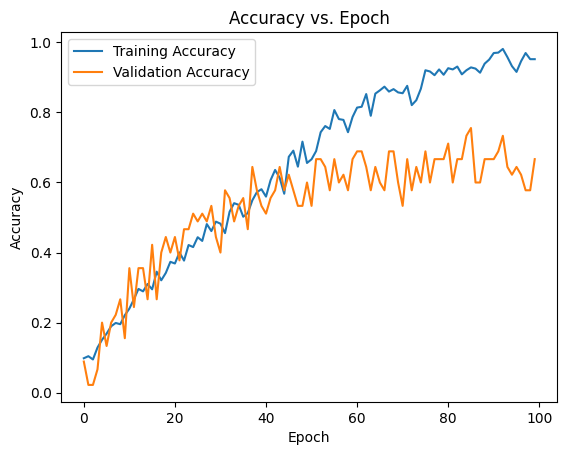

In [218]:
# Plot the accuracy across epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.show()

4/4 [==============================] - 1s 21ms/step
Confusion Matrix:
[[ 5  1  4  0  0  1  0  0  1  1]
 [ 0  4  0  0  0  2  0  0  0  0]
 [ 1  0  3  0  0  1  0  0  0  0]
 [ 1  0  0  5  1  0  0  2  1  0]
 [ 0  0  0  1  3  0  0  1  2  1]
 [ 3  1  2  0  0 10  0  1  0  0]
 [ 0  0  0  0  1  0 11  0  0  0]
 [ 2  1  0  0  3  0  0  3  1  0]
 [ 0  0  1  2  2  0  0  2  6  0]
 [ 2  0  0  1  1  0  0  0  1  1]]


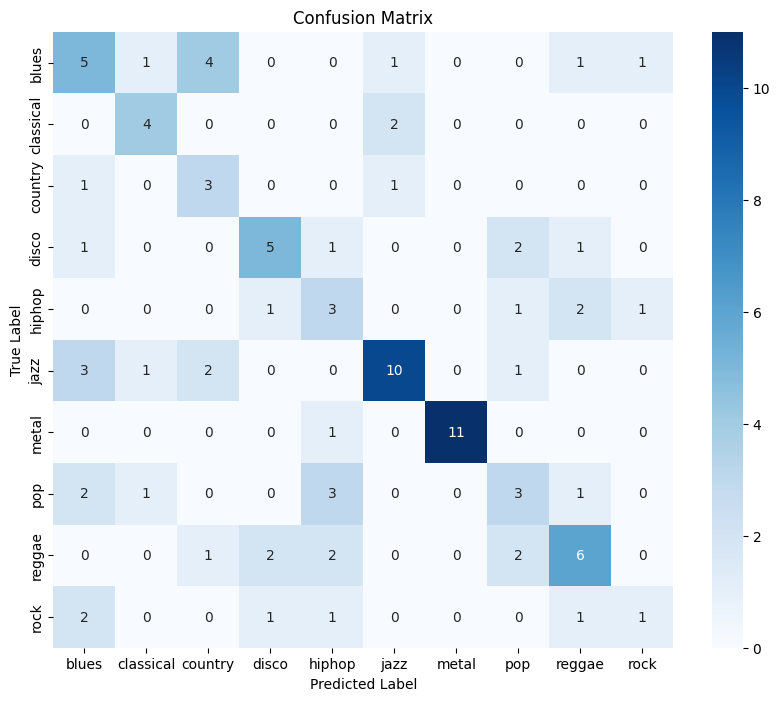

In [219]:
# Evaluate the model
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [220]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

       blues       0.36      0.38      0.37        13
   classical       0.57      0.67      0.62         6
     country       0.30      0.60      0.40         5
       disco       0.56      0.50      0.53        10
      hiphop       0.27      0.38      0.32         8
        jazz       0.71      0.59      0.65        17
       metal       1.00      0.92      0.96        12
         pop       0.33      0.30      0.32        10
      reggae       0.50      0.46      0.48        13
        rock       0.33      0.17      0.22         6

    accuracy                           0.51       100
   macro avg       0.49      0.50      0.48       100
weighted avg       0.53      0.51      0.51       100

